In [68]:
#必要なライブラリのインポート

import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb

from datetime import datetime
from datetime import timedelta
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [69]:
#使用する関数の定義

#開始日から終了日までの日付を返す
def daterange(_start, _end):
    count = (_end - _start).days / 10.0
    for n in range(int(count)):
        yield _start + timedelta(n*10)
        

start = datetime.strptime('2019-12-31', '%Y-%m-%d')
end   = datetime.strptime('2020-05-29', '%Y-%m-%d')

#ちゃんと10日ごとのデータとなっているかの確認
ntlsample = pd.DataFrame([i for i in daterange(start, end)], columns=['Date'])

In [70]:
#コロナデータをpdデータとして読み込み
pd_COVID         = pd.read_csv('/kaggle/input/ntt-data-global-ai-challenge-06-2020/COVID-19_and_Price_dataset.csv')    
#日付データとアメリカデータのみ抽出
#pd_COVID_USA     = pd_COVID[['Date',country_name + '_total_cases', country_name + '_new_cases',country_name + '_total_deaths',country_name + '_new_deaths']]
#日付列をインデックスにする
pd_COVID_key = pd_COVID.set_index('Date')





In [71]:
#オイルデータをpdデータとして読み込み
pd_Crude_oil      = pd.read_csv('/kaggle/input/ntt-data-global-ai-challenge-06-2020/Crude_oil_trend_From1986-01-02_To2020-06-08.csv')
#日付列をインデックスにする
pd_Crude_oil_key  = pd_Crude_oil.set_index('Date')
#2020年からのデータのみ抽出
pd_Crude_oil_2020 = pd_Crude_oil_key['2019-12-31':]


In [72]:
#①コロナデータを元にモデルを作成(重回帰分析)

#データの前処理
train = pd_COVID_key

#目的変数：石油価格
y = np.array(train['Price']).reshape(-1,1)

#説明変数：世界の新規コロナデータ全量
x = np.array(train[train.columns[train.columns.str.contains('new')]])

#説明変数：フランス、イタリア、中国、アメリカの新規感染者数・新規死者数(こっちは精度高い)
#x = np.array(train[['UnitedStates_new_cases','UnitedStates_new_deaths','Italy_new_cases','Italy_new_deaths','China_new_cases','China_new_deaths','France_new_cases','France_new_deaths']])
#print(x.shape)

#データの標準化
sscaler = preprocessing.StandardScaler()
sscaler.fit(x)
xss_sk = sscaler.transform(x) 
sscaler.fit(y)
yss_sk = sscaler.transform(y)

# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(xss_sk, y, test_size=0.3, random_state=0)



In [73]:
#①コロナデータを元にモデルを作成(重回帰分析)

#モデルの作成
#回帰モデル
model = LinearRegression()
#学習はfit
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

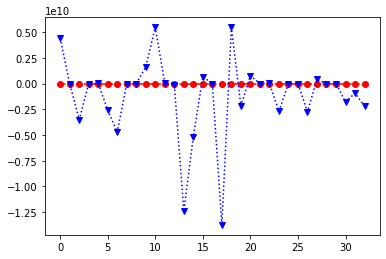

In [74]:
#プロット
import matplotlib.pyplot as plt

#x = X_test
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
y1 = Y_test
y2 = Y_pred
plt.plot(x, y1, marker="o", color = "red", linestyle = "--")
plt.plot(x, y2, marker="v", color = "blue", linestyle = ":")
plt.show()

重回帰分析では全く正確な結果は出ない。
そのため、ここから下では勾配ブースティングを用いている。

[09:38:42] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:34.05305	eval-rmse:34.09890
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:24.19221	eval-rmse:24.39162
[2]	train-rmse:17.20425	eval-rmse:17.48380
[3]	train-rmse:12.23340	eval-rmse:12.54298
[4]	train-rmse:8.71290	eval-rmse:9.01854
[5]	train-rmse:6.21236	eval-rmse:6.53954
[6]	train-rmse:4.43149	eval-rmse:4.80681
[7]	train-rmse:3.16667	eval-rmse:3.60354
[8]	train-rmse:2.26936	eval-rmse:2.77372
[9]	train-rmse:1.62928	eval-rmse:2.21590
[10]	train-rmse:1.17444	eval-rmse:1.86580
[11]	train-rmse:0.85181	eval-rmse:1.68308
[12]	train-rmse:0.62277	eval-rmse:1.54243
[13]	train-rmse:0.45760	eval-rmse:1.47050
[14]	train-rmse:0.34048	eval-rmse:1.43387
[15]	train-rmse:0.25345	eval-rmse:1.39962
[16]	train-rmse:0.19082	eval-rmse:1.38268
[17]	train-rmse:0.

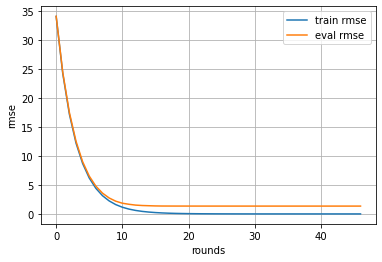

In [75]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

xgb_params = {
    # 回帰問題
    'objective': 'reg:linear',
    # 学習用の指標 (RMSE)
    'eval_metric': 'rmse',
}
evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}
bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=1000,
                early_stopping_rounds=10,
                evals=evals,
                evals_result=evals_result,
                )

Y_pred = bst.predict(dtest)
mse = mean_squared_error(Y_test, Y_pred)
print('RMSE:', math.sqrt(mse))

train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

上記のグラフは、繰り返し予測を行う中で、誤差が収束していっていることを表している。
RMSEは予測と実測値の「2乗平均平方根誤差」


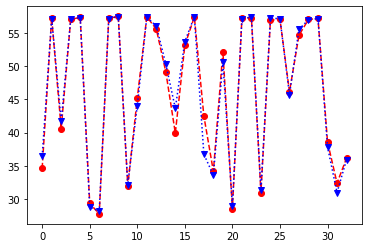

In [76]:
#x = X_test
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
y1 = Y_test
y2 = Y_pred
plt.plot(x, y1, marker="o", color = "red", linestyle = "--")
plt.plot(x, y2, marker="v", color = "blue", linestyle = ":")
plt.show()

コロナデータのみの利用でもそれなりの結果にはなっていることがわかる。

In [77]:
a = np.concatenate([Y_test.reshape(-1,1), Y_pred.reshape(-1,1)], 1)
columns = ['real','pred']
pr = pd.DataFrame(data=a, columns=columns, dtype='float')
pr

,real,pred
0,34.609733,36.428715
1,57.253467,57.174366
2,40.611200,41.716682
3,57.033733,57.070225
4,57.359600,57.320564
5,29.341200,28.818487
6,27.750267,28.145224
7,57.193067,57.174366
8,57.521733,57.469025
9,32.009067,32.156029


しかし、実際の値を見てみると、大きいところでは5円以上の誤差が発生している。。。